In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import k3d
import matplotlib.pyplot as plt
from sloppy.optic import *
from sloppy.raytracing import *
from sloppy.abcd import *
from sloppy.utils import *
from sloppy.tools import *

In [3]:
def LensCav(fgrin=1.5, flong=100.0, eps_grin=0.0, eps_long=-4.0, lens_diam=25.4, grin_diam=3.0, grin_thick=1.5, lens_thick=6.0):

    p_grin_f = fgrin + eps_grin
    p_grin_b = p_grin_f + grin_thick
    p_long_f = p_grin_b + fgrin + flong + eps_long
    p_long_b = p_long_f + lens_thick
    p_mirr = p_long_b + flong
    
    p0 = np.array([0,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])
    p3 = np.array([0,0,p_long_b])
    p4 = np.array([0,0,p_mirr])

    e = np.array([0,0,5.0])*0
    
    pm0 = np.array([0,0,-p_grin_f])
    pm1 = np.array([0,0,-p_grin_b])
    pm2 = np.array([0,0,-p_long_f])
    pm3 = np.array([0,0,-p_long_b])
    pm4 = np.array([0,0,-p_mirr])

    
    
    ii = lens_diam
    hi = 12.7
    qi=7.75
    ng = 1.4537

    Rgrin = (ng-1)*fgrin
    Rlong = (ng-1)*flong
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    screen = Screen(n=nzm, ax=axzm)
    
    # negative sign of first cuved surface for abcd matrix
    elements = [screen,
                Glass(p=p0, n=nz, ax=axz, diameter=grin_diam, n2=ng),
                CurvedGlass(p=p1, n=nz, ax=axz, diameter=grin_diam, R=-Rgrin, curv='CC', n1=ng),
                Glass(p=p2, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3, n=nz, ax=axz, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=p4, n=nz, ax=axz, diameter=ii),
                #backwards pass
                CurvedGlass(p=p3+e, n=nzm, ax=axzm, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=p2+e, n=nzm, ax=axzm, diameter=ii, n1=ng),
                CurvedGlass(p=p1+e, n=nzm, ax=axzm, diameter=grin_diam, R=Rgrin, curv='CX', n2=ng),
                Glass(p=p0+e, n=nzm, ax=axzm, diameter=grin_diam, n1=ng),
                #left half
                Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
                CurvedGlass(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, R=-Rgrin, curv='CC', n1=ng),
                Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
                CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii),
                #backwards pass
                CurvedGlass(p=pm3+e, n=nz, ax=axz, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=pm2+e, n=nz, ax=axz, diameter=ii, n1=ng),
                CurvedGlass(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, R=Rgrin, curv='CX', n2=ng),
                Glass(p=pm0+e, n=nz, ax=axz, diameter=grin_diam, n1=ng),]

    return elements

In [5]:
def LensCavAsph(flong=100.0, eps_grin=0.0, eps_long=-4.0, eps_mirr=-4.0, lens_diam=25.4, grin_diam=2.4, grin_thick=1.020, lens_thick=6.0):
    
    wdgrin = 0.8
    fgrin=1.5
    
    p_grin_f = wdgrin + eps_grin
    p_grin_b = p_grin_f + grin_thick
    p_long_f = p_grin_b + fgrin + flong + eps_long
    p_long_b = p_long_f + lens_thick
    p_mirr = p_long_b + flong + eps_mirr
    
    p0 = np.array([0,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])
    p3 = np.array([0,0,p_long_b])
    p4 = np.array([0,0,p_mirr])

    e = np.array([0,0,5.0])*0
    
    pm0 = np.array([0,0,-p_grin_f])
    pm1 = np.array([0,0,-p_grin_b])
    pm2 = np.array([0,0,-p_long_f])
    pm3 = np.array([0,0,-p_long_b])
    pm4 = np.array([0,0,-p_mirr])

    
    
    ii = lens_diam
    hi = 12.7
    qi=7.75
    ng = 1.4537

    # Rgrin = (ng-1)*fgrin
    Rlong = (ng-1)*flong
    # now C140 instead of "spherical" GRIN lens
    Rgrin = -0.840660
    k=-0.963070
    An=[-9.476566e-2, -2.790461e-2, -5.415580e-3, -3.553653e-3]
    
    coeff = np.array([Rgrin, k,] + An) #these coefficients go _away_ from the normal
    coeffm = coeff*-1 #these coefficients go _to_ the normal
    coeffm[1] = k
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    screen = Screen(n=nzm, ax=axzm)
    
    # negative sign of first cuved surface for abcd matrix
    elements = [screen,
                Glass(p=p0, n=nz, ax=axz, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=p1, n=nz, ax=axz, diameter=grin_diam, n1=ng, coef=coeffm), #R=-Rgrin,
                Glass(p=p2, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3, n=nz, ax=axz, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=p4, n=nz, ax=axz, diameter=ii),
                #backwards pass
                CurvedGlass(p=p3+e, n=nzm, ax=axzm, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=p2+e, n=nzm, ax=axzm, diameter=ii, n1=ng),
                ThorlabsAsphere(p=p1+e, n=nzm, ax=axzm, diameter=grin_diam, n2=ng, coef=coeff), #R=-Rgrin,
                Glass(p=p0+e, n=nzm, ax=axzm, diameter=grin_diam, n1=ng),
                #left half
                Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, n1=ng, coef=coeffm),
                Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
                CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii),
                #backwards pass
                CurvedGlass(p=pm3+e, n=nz, ax=axz, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=pm2+e, n=nz, ax=axz, diameter=ii, n1=ng),
                ThorlabsAsphere(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, n2=ng, coef=coeff),
                Glass(p=pm0+e, n=nz, ax=axz, diameter=grin_diam, n1=ng),]

    return elements

In [5]:
def LensCavML(flong=75.0, fmla=6.0, eps_grin=0.0, eps_long=-4.0, eps_mirr=0.0, eps_mla=0.0, lens_diam=25.4, grin_diam=2.4, grin_thick=1.020, lens_thick=6.0, mla_thick=2.0):
    
    wdgrin = 0.8
    fgrin=1.5
    
    p_grin_f = wdgrin + eps_grin
    p_grin_b = p_grin_f + grin_thick
    p_long_f = p_grin_b + fgrin + flong + eps_long
    p_long_b = p_long_f + lens_thick
    p_mirr = p_long_b + flong + eps_mirr
    p_mla_f = p_long_b + flong + eps_mla
    p_mla_b = p_mla_f + mla_thick 
    p_mirr_mla = p_mla_b + fmla + eps_mirr - eps_mla
    
    p0 = np.array([0,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])
    p3 = np.array([0,0,p_long_b])
    p3b = np.array([0,0,p_mla_f])
    p3c = np.array([0,0,p_mla_b])
    p4 = np.array([0,0,p_mirr_mla])

    e = np.array([0,0,5.0])*0
    
    pm0 = np.array([0,0,-p_grin_f])
    pm1 = np.array([0,0,-p_grin_b])
    pm2 = np.array([0,0,-p_long_f])
    pm3 = np.array([0,0,-p_long_b])
    pm4 = np.array([0,0,-p_mirr])

    
    
    ii = lens_diam
    hi = 12.7
    qi=7.75
    ng = 1.4537

    Rmla = (ng-1)*fmla
    Rlong = (ng-1)*flong
    # now C140 instead of "spherical" GRIN lens
    Rgrin = -0.840660
    k=-0.963070
    An=[-9.476566e-2, -2.790461e-2, -5.415580e-3, -3.553653e-3]
    
    coeff = np.array([Rgrin, k,] + An) #these coefficients go _away_ from the normal
    coeffm = coeff*-1 #these coefficients go _to_ the normal
    coeffm[1] = k
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    screen = Screen(n=nzm, ax=axzm)
    
    # negative sign of first cuved surface for abcd matrix
    elements = [screen,
                Glass(p=p0, n=nz, ax=axz, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=p1, n=nz, ax=axz, diameter=grin_diam, R=Rgrin, n1=ng, coef=coeffm), #R=-Rgrin,
                Glass(p=p2, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3, n=nz, ax=axz, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Glass(p=p3b, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3c, n=nz, ax=axz, diameter=ii, R=-Rmla, curv='CC', n1=ng),
                Mirror(p=p4, n=nz, ax=axz, diameter=ii),
                #backwards pass
                CurvedGlass(p=p3c+e, n=nzm, ax=axzm, diameter=ii, R=Rmla, curv='CX', n2=ng),
                Glass(p=p3b+e, n=nzm, ax=axzm, diameter=ii, n1=ng),
                
                CurvedGlass(p=p3+e, n=nzm, ax=axzm, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=p2+e, n=nzm, ax=axzm, diameter=ii, n1=ng),
                ThorlabsAsphere(p=p1+e, n=nzm, ax=axzm, diameter=grin_diam, R=-Rgrin, n2=ng, coef=coeff), #R=-Rgrin,
                Glass(p=p0+e, n=nzm, ax=axzm, diameter=grin_diam, n1=ng),
                #left half
                Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
                #CurvedGlass(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, R=-Rgrin, curv='CC', n1=ng),
                ThorlabsAsphere(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, R=Rgrin, n1=ng, coef=coeffm),
                Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
                CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii),
                #backwards pass
                CurvedGlass(p=pm3+e, n=nz, ax=axz, diameter=ii, R=Rlong, curv='CX', n2=ng),
                Glass(p=pm2+e, n=nz, ax=axz, diameter=ii, n1=ng),
                #CurvedGlass(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, R=Rgrin, curv='CX', n2=ng),
                ThorlabsAsphere(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, R=-Rgrin, n2=ng, coef=coeff),
                Glass(p=pm0+e, n=nz, ax=axz, diameter=grin_diam, n1=ng),]

    return elements

In [30]:
def LensCavAsphSimple(flong=100.0, eps_grin=0.0, eps_long=-4.0, eps_mirr=-4.0, lens_diam=25.4, grin_diam=2.4, grin_thick=1.020, lens_thick=6.0):
    
    wdgrin = 0.8
    fgrin=1.5
    
    p_grin_f = wdgrin + eps_grin
    p_grin_b = p_grin_f + grin_thick
    p_long_f = p_grin_b + fgrin + flong + eps_long
    p_long_b = p_long_f + lens_thick
    p_mirr = p_long_b + flong + eps_mirr
    
    p0 = np.array([0,0,p_grin_f])
    p1 = np.array([0,0,p_grin_b])
    p2 = np.array([0,0,p_long_f])
    p3 = np.array([0,0,p_long_b])
    p4 = np.array([0,0,p_mirr])

    e = np.array([0,0,5.0])*0
    
    pm0 = np.array([0,0,-p_grin_f])
    pm1 = np.array([0,0,-p_grin_b])
    pm2 = np.array([0,0,-p_long_f])
    pm3 = np.array([0,0,-p_long_b])
    pm4 = np.array([0,0,-p_mirr])

    
    
    ii = lens_diam
    hi = 12.7
    qi=7.75
    ng = 1.4537

    # Rgrin = (ng-1)*fgrin
    Rlong = (ng-1)*flong
    # now C140 instead of "spherical" GRIN lens
    Rgrin = -0.840660
    k=-0.963070
    An=[-9.476566e-2, -2.790461e-2, -5.415580e-3, -3.553653e-3]
    
    coeff = np.array([Rgrin, k,] + An) #these coefficients go _away_ from the normal
    coeffm = coeff*-1 #these coefficients go _to_ the normal
    coeffm[1] = k
    
    nz = (0., 0. ,-1.0)
    nzm = (0., 0. ,1.0)
    axz = (-1, 0, 0)
    axzm = (1, 0, 0)

    screen = Screen(n=nzm, ax=axzm)
    screen2 = Screen(n=nzm, ax=axzm)

# #backwards pass
#                 CurvedGlass(p=p3+e, n=nzm, ax=axzm, diameter=ii, R=Rlong, curv='CX', n2=ng),
#                 Glass(p=p2+e, n=nzm, ax=axzm, diameter=ii, n1=ng),
#                 ThorlabsAsphere(p=p1+e, n=nzm, ax=axzm, diameter=grin_diam, n2=ng, coef=coeff), #R=-Rgrin,
#                 Glass(p=p0+e, n=nzm, ax=axzm, diameter=grin_diam, n1=ng),
#                 #left half
#                 Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
#                 ThorlabsAsphere(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, n1=ng, coef=coeffm),
#                 Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
#                 CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
#                 Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii),
#                 #backwards pass
#                 CurvedGlass(p=pm3+e, n=nz, ax=axz, diameter=ii, R=Rlong, curv='CX', n2=ng),
#                 Glass(p=pm2+e, n=nz, ax=axz, diameter=ii, n1=ng),
#                 ThorlabsAsphere(p=pm1+e, n=nz, ax=axz, diameter=grin_diam, n2=ng, coef=coeff),
#                 Glass(p=pm0+e, n=nz, ax=axz, diameter=grin_diam, n1=ng),
    
    # negative sign of first cuved surface for abcd matrix
    elements_r = [
                Glass(p=p0, n=nz, ax=axz, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=p1, n=nz, ax=axz, diameter=grin_diam, n1=ng, coef=coeffm), #R=-Rgrin,
                Glass(p=p2, n=nz, ax=axz, diameter=ii, n2=ng),
                CurvedGlass(p=p3, n=nz, ax=axz, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                ]

    elements_l = [Glass(p=pm0, n=nzm, ax=axzm, diameter=grin_diam, n2=ng),
                ThorlabsAsphere(p=pm1, n=nzm, ax=axzm, diameter=grin_diam, n1=ng, coef=coeffm),
                Glass(p=pm2, n=nzm, ax=axzm, diameter=ii, n2=ng),
                CurvedGlass(p=pm3, n=nzm, ax=axzm, diameter=ii, R=-Rlong, curv='CC', n1=ng),
                ]

    return [screen, *elements_r, Mirror(p=p4, n=nz, ax=axz, diameter=ii), *(elements_r[::-1]), *elements_l, Mirror(p=pm4, n=nzm, ax=axzm, diameter=ii), *(elements_l[::-1]), screen2]

In [31]:
elements = LensCavAsphSimple(eps_long=-4.2, eps_grin=0)
screen = elements[0]
sys = RaySystem(elements, add_screen=False)
sys.screen = screen

# mu = np.array([0.5, 0., 0., 0.])
# mu = np.stack([[0.0, 0., sx, 0.] for sx in np.linspace(-0.1, 0.1, 7)*0.05], axis=0)
mu = np.stack([[xx, 0., 0., 0.] for xx in np.linspace(-0.1, 0.1, 7)*0.1], axis=0)
ray = sys.screen.eigenvectors_to_rays(mu)

# ray = sys.screen.eigenvectors_to_rays(system.q)

In [32]:
traj = sys.propagate(ray, at_screen=False, clip=False)

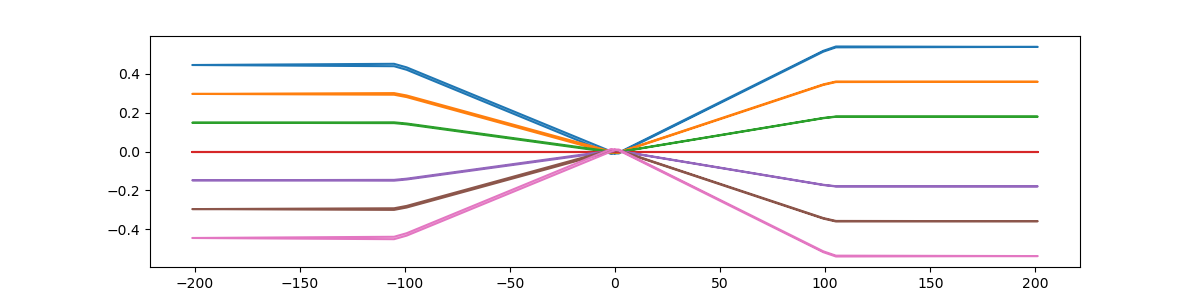

In [33]:
plt.figure(figsize=(12, 3))
for i in range(traj.shape[2]):
    plt.plot(traj[:, 0, i, 2], traj[:, 0, i, 0])
plt.show()

In [18]:
try:
    plot.close()
except:
    pass
plot = k3d.plot(camera_auto_fit=True, antialias=True)

for i, el in enumerate(sys.elements):
    if not isinstance(el, Screen):
        plot += el.plot(opacity=0.4)

for i, el in enumerate(sys.elements):
    plot_element_ax(el, plot, length=2.)

# plot_rays(ray, plot)
plot_trajs(traj[0:7], plot)
plot_trajs(traj[6:], plot, color=0x555500)

plot.display()

C:\Users\lukas\.conda\envs\sloppy\lib\site-packages\traittypes\traittypes.py:101: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  np.dtype(self.dtype).name))
c:\users\lukas\documents\phd\sloppy\src\sloppy\optic.py:242: RuntimeWarning: invalid value encountered in sqrt
  z = R-np.sqrt(R**2-x**2-y**2)


Output()

In [25]:
cavfct = LensCavAsphSimple
parname = 'eps_grin'
res = degeneracy_length(cavfct, parname, 1)
Ldeg = res.x
print(res)
elements = cavfct(**{parname: Ldeg})
sys = RaySystem(elements)
system = sys.abcd
mu1, mu2 = system.q

 message: NaN result encountered.
 success: False
  status: 2
     fun: nan
       x: 0.0
     nit: 1
    nfev: 1


In [10]:
def _cavity_parameter_interaction_factory(cavfct, parname, scanrange, N = 300):
    fig, ax = plt.subplots(ncols=2, figsize=(8,4), sharex=True)
    lws = [ax[0].plot([0, 1], [0, 1])[0] for i in range(2)]
    ax[0].set_ylabel('um')
    lfs = [ax[1].plot([0, 1], [0, 1])[0] for i in range(4)]
    ax[1].set_ylabel('MHz')
    axh1 = ax[1].axhline(0, color='grey')
    axv0 = ax[0].axvline(0, color='grey')
    axv1 = ax[1].axvline(0, color='grey')
    plt.show()
    
    def update_waists_vs_params(cavfct, parname, scanrange, N = 300, **kwargs):
        stab = lambda m: abs(0.5*np.trace(m))<1
        scanrange=[-5, 3]
        La = kwargs[parname]
        Las = La + np.linspace(-scanrange[0], scanrange[0], N)
        ms = np.zeros((N))
        ws = np.zeros((N,2))
        freqs = np.zeros((N,4))
        for i, l in enumerate(Las):
            pardct = kwargs.copy()
            pardct.update({parname: l})
            sys = RaySystem( cavfct(**pardct) )

            try:
                system = sys.abcd
                w = system.waist_at(0)
            except:
                ws[i,:] = np.nan
                ms[i] = np.nan
                freqs[i,...] = np.nan
            else:
                ms[i] = stab(system.abcd_rt)
                ws[i,:] = np.sort(w)
                freqs[i,...] = np.concatenate(system.get_freqs(s=1))
                #ft, fs3 = system.get_freqs()
                #fsr = system.fsr
                #freqs[i,...] = np.concatenate((ft, np.mod(3*ft, fsr)))
                idx = np.argmin(np.abs(freqs[:,2]))
        for i in range(2):
            lws[i].set_data(np.stack((Las, ws[:,i]*1e3), axis=0))
        for i in range(4):
            lfs[i].set_data(np.stack((Las, freqs[:,i]*1e-6), axis=0))
        axv0.set_xdata([Las[idx], Las[idx]])
        axv1.set_xdata([Las[idx], Las[idx]])
        Ldeg = Las[idx]
        ax[0].set_xlim(Las[0], Las[-1])
        ax[0].set_ylim(0.8*np.nanmin(ws*1e3), 1.1*np.nanmax(ws*1e3))
        ax[1].set_ylim(0.8*np.nanmin(freqs*1e-6), 1.1*np.nanmax(freqs*1e-6))
        fig.canvas.draw_idle()
    
    _magnitude = lambda x: 1. if abs(x)<0.1 else int(np.floor(np.log10(abs(x))))
    _sgn = lambda x: 1 if x>0 else -1
    _min = lambda x: -1 if x==0 else (1.5*x if x<0 else 0.5*x)
    _max = lambda x: 1 if x==0 else (0.5*x if x<0 else 1.5*x)

    
    lo = Layout(width='80%', height='30px')
    for v in inspect.signature(cavfct).parameters.values():
        print(v.name, v.default)
    sliders = {v.name: FloatSlider(value=v.default, min=_min(v.default), max=_max(v.default), step=10**(_magnitude(v.default)-2), readout_format='.2e', layout=lo) for v in inspect.signature(cavfct).parameters.values()}
    sliders.update({'scanrange': FloatLogSlider(value=scanrange, min=-3, max=1, step=0.5, layout=lo)})
    return interactive(update_waists_vs_params, cavfct=fixed(cavfct), parname = fixed('eps_grin'), N=fixed(N), **sliders)

In [16]:
_cavity_parameter_interaction_factory(LensCavML, 'eps_grin',0.1, N=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

flong 75.0
fmla 6.0
eps_grin 0.0
eps_long -4.0
eps_mirr 0.0
eps_mla 0.0
lens_diam 25.4
grin_diam 2.4
grin_thick 1.02
lens_thick 6.0
mla_thick 2.0


interactive(children=(FloatLogSlider(value=0.1, description='scanrange', layout=Layout(height='30px', width='8…

In [35]:
cavfct = LensCavML
elements = cavfct(eps_long=-5.3, eps_grin=-0.0)
sys = RaySystem(elements)
system = sys.abcd
mu1, mu2 = system.q

In [36]:
sys.elements

In [50]:
pos = [e.p for e in sys.elements]

abcd = []
for i, el in enumerate(sys.elements):
    if i>0:
        d = np.linalg.norm(pos[i-1]-pos[i])
    else:
        d = 0
    print(i, el, d)
    if isinstance(el, Glass) or isinstance(el, CurvedGlass) or isinstance(el, FreeFormInterface) or isinstance(el, ThorlabsAsphere):
        #modify index of refraction in propagation according to Glass element
        abcd.extend([Prop(d, n=el.n1), ABCD(el.m), ABCD(el.Rbasis)])
    else:
        abcd.extend([Prop(d), ABCD(el.m), ABCD(el.Rbasis)])

0 <sloppy.optic.Screen object at 0x000001B195766188> 0
1 <sloppy.optic.Glass object at 0x000001B193C30088> 0.8
2 <sloppy.optic.ThorlabsAsphere object at 0x000001B193BF3988> 1.02
3 <sloppy.optic.Glass object at 0x000001B193BF3D48> 71.2
4 <sloppy.optic.CurvedGlass object at 0x000001B19266B208> 6.0
5 <sloppy.optic.Glass object at 0x000001B1953E4B88> 74.99999999999999
6 <sloppy.optic.CurvedGlass object at 0x000001B1953E4C88> 2.0
7 <sloppy.optic.Mirror object at 0x000001B1953E47C8> 6.0
8 <sloppy.optic.CurvedGlass object at 0x000001B1936A1908> 6.0
9 <sloppy.optic.Glass object at 0x000001B1959B4448> 2.0
10 <sloppy.optic.CurvedGlass object at 0x000001B1936A1A88> 74.99999999999999
11 <sloppy.optic.Glass object at 0x000001B1936A12C8> 6.0
12 <sloppy.optic.ThorlabsAsphere object at 0x000001B1936A1408> 71.2
13 <sloppy.optic.Glass object at 0x000001B19D323808> 1.02
14 <sloppy.optic.Glass object at 0x000001B19D323CC8> 1.6
15 <sloppy.optic.ThorlabsAsphere object at 0x000001B19D323F48> 1.02
16 <sloppy.

In [51]:
system = ABCDSystem(abcd)

In [52]:
sys.elements[2].p

array([0.  , 0.  , 1.82])

In [53]:
system.elements[4].m

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [0.        , 0.        , 0.68789984, 0.        ],
       [0.        , 0.        , 0.        , 0.68789984]])

In [54]:
for i, e in enumerate(system.elements):
    if not np.allclose(e.m, np.identity(4, dtype=np.float64)): 
        print(i, type(e), e.x)

3 <class 'sloppy.abcd.Prop'> 0.0
4 <class 'sloppy.abcd.ABCD'> 0.8
6 <class 'sloppy.abcd.Prop'> 0.8
7 <class 'sloppy.abcd.ABCD'> 1.82
9 <class 'sloppy.abcd.Prop'> 1.82
10 <class 'sloppy.abcd.ABCD'> 73.02
12 <class 'sloppy.abcd.Prop'> 73.02
13 <class 'sloppy.abcd.ABCD'> 79.02
15 <class 'sloppy.abcd.Prop'> 79.02
16 <class 'sloppy.abcd.ABCD'> 154.01999999999998
18 <class 'sloppy.abcd.Prop'> 154.01999999999998
19 <class 'sloppy.abcd.ABCD'> 156.01999999999998
21 <class 'sloppy.abcd.Prop'> 156.01999999999998
24 <class 'sloppy.abcd.Prop'> 162.01999999999998
25 <class 'sloppy.abcd.ABCD'> 168.01999999999998
27 <class 'sloppy.abcd.Prop'> 168.01999999999998
28 <class 'sloppy.abcd.ABCD'> 170.01999999999998
30 <class 'sloppy.abcd.Prop'> 170.01999999999998
31 <class 'sloppy.abcd.ABCD'> 245.01999999999998
33 <class 'sloppy.abcd.Prop'> 245.01999999999998
34 <class 'sloppy.abcd.ABCD'> 251.01999999999998
36 <class 'sloppy.abcd.Prop'> 251.01999999999998
37 <class 'sloppy.abcd.ABCD'> 322.21999999999997
39 

In [57]:
x = np.linspace(0, system.Ltot, 5000)
ws = system.compute_waists(x)
plt.figure()
plt.plot(x, ws)
for i, e in enumerate(system.elements):
    if type(e)!=Prop:
        plt.axvline(e.x, color='grey', ls=':')
# plt.yscale('log')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [302]:
plt.close('all')

In [5]:
Npt = 20
a = 0.5
x = np.linspace(-a, a, Npt)
coords = np.meshgrid(x, x)

xy = np.stack(coords, axis=-1).reshape((-1,2))
#pxy = np.zeros_like(xy)
pxy = np.broadcast_to(np.array([0, 0]), xy.shape)
mu = np.concatenate((xy, pxy), axis=1)
ray = sys.screen.eigenvectors_to_rays(mu)

In [6]:
traj = sys.propagate(ray, at_screen=True)
pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])

In [7]:
plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=2.)
plt.scatter(pos[:,0], pos[:,1], s=2.)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [10]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

cavfct = LensCav
parname = 'lens_dist'

def update_xygrid(dl=0.0, a=0.1, px=1e-2, py=-1e-3, Nrt=3, Npts=20, **kwargs):
    res = degeneracy_length(cavfct, parname, 1e-3)
    Ldeg = res.x
    print(res)
    elements = cavfct(**{parname: Ldeg+dl})
    sys = RaySystem(elements)
    
    x = np.linspace(-a, a, Npts)
    coords = np.meshgrid(x, x)
    xy = np.stack(coords, axis=-1).reshape((-1,2))
    pxy = np.broadcast_to(np.array([px, -py]), xy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=True)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(xy)
    lineb.set_offsets(pos)
  
    #ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()
        
interactive(update_xygrid, dl=(-1, 1, 1e-3), a = (0,1,1e-2),\
            px=(-0.1,0.1,1e-3), py=(-0.1,0.1,1e-3), Nrt=(0,10,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', max=1.0, min=-1.0, step=0.001), FloatSlider(val…

In [31]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=2.)
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('px [mm]')
plt.ylabel('py [mm]')

cavfct = LensCav
parname = 'lens_dist'

def update_xygrid(dl=0.0, a=5e-2, x=0.004, y=-0.004, Nrt=3, Npts=20, **kwargs):
    res = degeneracy_length(cavfct, parname, 1e-3)
    Ldeg = res.x
    elements = cavfct(**{parname: Ldeg+dl})
    sys = RaySystem(elements)
    
    xx = np.linspace(-a*1e-1, a*1e-1, Npts)
    coords = np.meshgrid(xx, xx)
    pxy = np.stack(coords, axis=-1).reshape((-1,2))
    xy = np.broadcast_to(np.array([x, y]), pxy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, Nrt=Nrt, at_screen=True)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(pxy)
    lineb.set_offsets(pos)
    plt.xlim(1.5*np.nanmin(pxy[:,0]), 1.5*np.nanmax(pxy[:,0]))
    plt.ylim(1.5*np.nanmin(pxy[:,1]), 1.5*np.nanmax(pxy[:,1]))
    fig.canvas.draw_idle()
interactive(update_xygrid, dl=(-1, 1, 1e-3), a = (0,1,1e-3),\
            x=(-0.1,0.1,1e-3), y=(-0.1,0.1,1e-3), Nrt=(0,10,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=0.0, description='dl', max=1.0, min=-1.0, step=0.001), FloatSlider(val…

In [ ]:
res = degeneracy_length(cavfct, parname, 1e-3)
Ldeg = res.x
elements = cavfct(**{parname: Ldeg+dl})
sys = RaySystem(elements)

a = 0.004
pa = 0.006
xx = np.linspace(-a*1e-1, a*1e-1, Npts)
coords = np.meshgrid(xx, xx)
pxy = np.stack(coords, axis=-1).reshape((-1,2))
xy = np.broadcast_to(np.array([x, y]), pxy.shape)
mu = np.concatenate((xy, pxy), axis=1)
ray = sys.screen.eigenvectors_to_rays(mu)
traj = sys.propagate(ray, Nrt=Nrt, at_screen=True)
pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
linea.set_offsets(pxy)
lineb.set_offsets(pos)
plt.xlim(1.5*np.nanmin(pxy[:,0]), 1.5*np.nanmax(pxy[:,0]))
plt.ylim(1.5*np.nanmin(pxy[:,1]), 1.5*np.nanmax(pxy[:,1]))

In [35]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 6))
ms = 8.
linea = plt.scatter(xy[:,0], xy[:,1], s=1., marker='.')
lineb = plt.scatter(pos[:,0], pos[:,1], s=2.)
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

def update_xygrid6(dl=Ldeg, dz=1.5825, a=0.1, px=1e-2, py=-1e-3, Nrt=1, Npts=20, **kwargs):
    elements, _ = SixMirror(dx=dl, dzF=dz)
    sys = RaySystem(elements)
    
    x = np.linspace(-a, a, Npts)
    coords = np.meshgrid(x, x)
    xy = np.stack(coords, axis=-1).reshape((-1,2))
    pxy = np.broadcast_to(np.array([px, -py]), xy.shape)
    mu = np.concatenate((xy, pxy), axis=1)
    ray = sys.screen.eigenvectors_to_rays(mu)
    traj = sys.propagate(ray, at_screen=True, Nrt=Nrt)
    pos = sys.screen.r_to_screen_coords(traj[-1,0,:,:])
    linea.set_offsets(xy)
    lineb.set_offsets(pos)
  
    ax.relim()
    #ax.autoscale_view()
    fig.canvas.draw_idle()
        
interactive(update_xygrid6, dl=(Ldeg-1, Ldeg+1, 1e-2), dz=(0, 1.5825, 1e-2), a = (0,1,1e-2),\
            px=(-0.1,0.1,1e-3), py=(-0.1,0.1,1e-3), Nrt=(1,11,1), Npts=(10, 100, 10))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(FloatSlider(value=27.768298126226423, description='dl', max=28.768298126226423, min=26.7…

In [29]:
plt.close("all")